# Comp Econ -- Homework Set 11

daniel csaba

uni id: N12155064

May 2016

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection

## Roadmap

The following script computes the stationary densities in the context of application 4.1 from the Stocahstic stability in monotone economies (Kamihigashi & Stachurski, 2014) paper. The method uses Howard's policy function iteration for computing the optimal consumption policy and the look-ahead estimator to compute the stationary densities once we have the optimal policy.

Elaborating a bit on the steps:

**Howard's policy function iteration**

+ pick a policy, $\sigma$, on the defined grid

+ evaluate $v_{\sigma}$ using the fact that it is the fixed point of the operator $Tw = r_{\sigma} + \beta P_{\sigma}w$

+ for this end first define
    + $r_{\sigma}$ -- implemented by `u`
    + $P_{\sigma}$ -- implemented by `transition_matrix`
    + then use the formula for Neumann series to get the fixed point $v_{\sigma}$ -- implemented by `value_func`
    
+ choose new $v_{\sigma}$-greedy policy, $\sigma'$

+ for this end use
    + `transition_kernel` -- probability density over next period states in a given state (no need to compute the whole matrix)
    + find $v_{\sigma}$-greedy consumption policy for each state -- implemented by `greedy_pol`
    + loop over each state and get updated policy (an array over the grid) -- implemented by `update`
    
+ iterate over policies till convergence is reached -- implemented by `Howard`


**Estimating the density**

+ given optimal policy function, $\sigma$, computed in the previous step simulate sample path
    + compute stocahstic transition matrix corresponding to $\sigma$
    + from current state get a random draw for next state using the corresponding row of the matrix
    + implemented by `simulated_path`
    
+ average over probabilities using the transition_matrix for the states that appear along the simulated path
    + implemented by `look_ahead`

In [21]:
class Renewable():
    
    def __init__(self, alpha, gamma, theta, a, b, c, d,
                 y_min, y_max, y_size, loc = -.1, scale = .2):
        
        # model parameters
        self.alpha, self.gamma, self.theta =  alpha, gamma, theta
        self.a, self.b, self.c, self.d = a, b, c, d
        self.loc, self.scale = loc, scale
        
        # grid parameters
        self.y_min = y_min
        self.y_max = y_max
        self.y_size = y_size
        
        # Grid uniformly placed in log not level
        self.y_grid = np.linspace(np.log(self.y_min), np.log(self.y_max), self.y_size)
        
            
    def u(self, x):
        """Reward function."""
        theta, gamma = self.theta, self.gamma
        return 1 - np.exp(-theta*x**gamma)
    
    def f(self, x):
        """Production function."""
        alpha, a, b, c, d = self.alpha, self.a, self.b, self.c, self.d
        
        l = a + (b - a)/(1 + np.exp(-c*(x - d)))
        return x**alpha * l
    
    
    def transition_kernel(self, x, c):
        """Define transition kernel for state x
        under consumption c.
        
        Parameters
        ==========
        x: given state
        c: consumption -- given by policy
        """
        
        y_grid = self.y_grid
        N = self.y_size
        d = self.y_grid[1] - self.y_grid[0]
        x_level = np.exp(x)
        
        # Empty to-be-stochastic matrix
        k = np.zeros(N)
        dist_y = norm(self.loc, self.scale)
        
        # Consuming everything in current period leaves one with zero resource with certainty
        if c == x_level:
            k[:] = np.zeros(N)
            k[0] = 1.0

        else:
            for i_y, y in enumerate(y_grid):
                y_bar = y

                y_dm = (y_bar - d/2) - np.log((self.f(x_level - c)))
                y_dp = (y_bar + d/2) - np.log((self.f(x_level - c)))

                # Tail probabilities
                if i_y == 0:
                    k[i_y] = dist_y.cdf(y_dp)

                elif i_y == (N - 1):
                    k[i_y] = 1 - dist_y.cdf(y_dm)

                # Interior probabilities
                else:
                    k[i_y] = dist_y.cdf(y_dp) - dist_y.cdf(y_dm)

        return k
                
    
    def transition_matrix(self, sigma):
        """Define transition probability from state x
        to state y given policy sigma.
        
        Parameters
        ==========
        sigma : policy function on grid
        """
        N = self.y_size
        
        P = np.zeros((N, N))
        
        for i_y, Y in enumerate(self.y_grid):        
            P[i_y, :] = self.transition_kernel(Y, sigma[i_y])
        
        return P
    
    
    def value_func(self, sigma, beta): # Neumann series
        """Evaluate policy sigma.
        
        Parameters
        ==========
        sigma: consumption policy over grid
        beta: discount factor
        """
        
        # Compute the Neuman series
        N = self.y_size
        P = self.transition_matrix(sigma)
        return np.linalg.inv(np.eye(N) - beta*P) @ self.u(sigma)
    

    
    def greedy_pol(self, beta, x, v):
        """Compute greedy policy for given state and given continuation value.
        
        Parameters
        ==========
        beta: discount factor
        x: current state in log
        v: continuation value
        """
        
        sol = minimize_scalar(lambda c: -self._aux_func(c, beta, x, v),
                              method = 'Bounded', bounds = (0, np.exp(x)))
        return sol.x
        
    def _aux_func(self, c, beta, x, v):
        """Auxiliary function for greedy policy."""
        
        return self.u(c) + beta * self.transition_kernel(x,c) @ v

    
    
    def update(self, sigma, beta):
        """Update policy function \sigma to v_{\sigma}-greedy policy \sigma'.
        
        Parameters
        ==========
        sigma: consumption policy over grid
        beta: discount factor
        """
        
        v = self.value_func(sigma, beta)
        N = self.y_size
        sigma_new = np.zeros(N)
        
        for i_x, x in enumerate(self.y_grid):
            sigma_new[i_x] = self.greedy_pol(beta, x, v)
            
        return sigma_new
    
    def Howard(self, sigma, beta, tol=1e-6, max_iter=100):
        """Iterate the policy function based on the greedy update.
        
        Parameters
        ==========
        sigma: consumption policy over grid
        beta: discount factor
        """
        
        dist = tol*2
        curr_iter = 0 
        
        while dist > tol and curr_iter < max_iter:
            sigma_new = self.update(sigma, beta)
            dist = max(abs(sigma_new - sigma))
            sigma = sigma_new
            curr_iter += 1
        
        return sigma
    
    def simulated_path(self, sigma, path_len):
        """Simulate path of length path_len for given beta, and policy sigma.
        
        Parameters
        ==========
        sigma: consumption policy over grid
        """
        
        N = self.y_size
        state_index = np.random.choice(np.arange(N))
        P = self.transition_matrix(sigma)
        sample_path = np.zeros(path_len, dtype = int)
        
        
        for i in range(path_len):
            next_state_index = np.int(np.random.choice(N, 1, p=P[state_index,:])[0])
            sample_path[i] = next_state_index
            state_index = next_state_index
            
        return self.y_grid[sample_path], sample_path
    
    def look_ahead(self, sigma, path_len, burn_in):
        """Use look ahead estimator with simulated path to get stationary density over states.
        
        Parameters
        ==========
        sigma: consumption policy over grid
        """
        
        path, index = self.simulated_path(sigma, path_len)
        
        Hist = np.zeros(self.y_size)
        b = 0
        
        for x, i in zip(path, index):
            if b > burn_in:
                Hist += self.transition_kernel(x, sigma[i])
            b += 1
            
        return Hist/(path_len - burn_in)

## parameters for the model
Initiate an instance of the class with the values used in the paper.

In [4]:
a, b, c, d = 1, 2, 20, 1
theta, gamma, alpha = .5, .9, .5

num_betas = 12
betas = np.linspace(.945, .99, num_betas)

num_gridpoints = 50

rm = Renewable(alpha, gamma, theta, a, b, c, d,
               y_min = np.exp(-2), y_max = np.exp(1.8), y_size = num_gridpoints)
policies_stored = np.zeros((num_gridpoints, num_betas))

## storing the policies

In [9]:
sigma0 = np.exp(rm.y_grid)/2 # initial guess for policy

for i, beta in enumerate(betas):
    policies_stored[:, i] = rm.Howard(sigma0, beta)

## plotting the policies

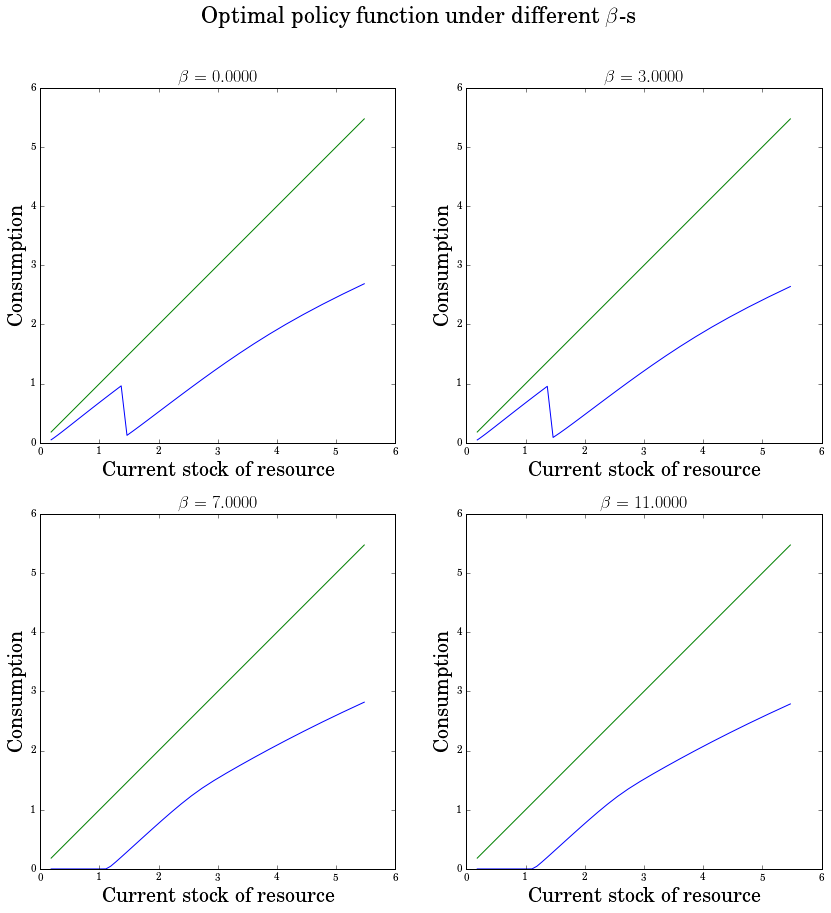

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
y_grid = np.exp(rm.y_grid)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


for ax, beta in zip(axes.flat, [0,3,7,11]):
    
    ax.plot(y_grid, policies_stored[:, beta])
    ax.plot(y_grid, y_grid)
    ax.set_ylabel(r'Consumption', fontsize = 20)
    ax.set_xlabel(r'Current stock of resource', fontsize = 20)
    ax.set_title(r'$\beta={:.04f}$'.format(beta), fontsize=18)
fig.suptitle(r'Optimal policy function under different $\beta$-s', fontsize=22)
plt.show()

## storing the densities

In [26]:
x = rm.y_grid
verts = []
policy = {}

for i in range(num_betas):
    y = rm.look_ahead(policies_stored[:, i], path_len = 5000, burn_in = 3000)
    y[0], y[-1] = 0, 0
    verts.append(list(zip(x,y)))

## plotting the densities

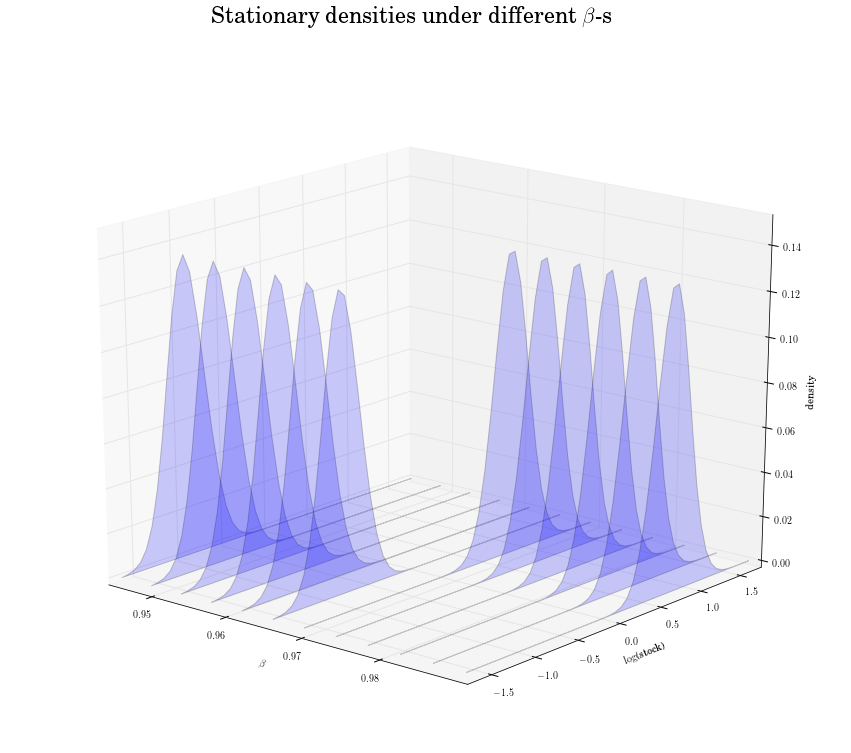

In [27]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca(projection='3d')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

poly = PolyCollection(verts, cmap='viridis')

poly.set_alpha(0.2)
ax.add_collection3d(poly, zs=betas, zdir='x')

ax.set_xlabel(r'$\beta$')
ax.set_xlim3d(.945, .99)
ax.set_ylabel(r'$\log$(stock)')
ax.set_ylim3d(-1.7, 1.7)
ax.set_zlabel(r'density')
ax.set_zlim3d(0, .15)
fig.suptitle(r'Stationary densities under different $\beta$-s', fontsize=22)
ax.view_init(20, 310)